## Import the Libraries

In [ ]:
!nvidia-smi

Tue May 31 04:29:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   30C    P8    11W / 120W |      0MiB /  8127MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install --upgrade pip
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install joblib
# !pip install sklearn
# !pip install lightgbm
# !pip install prettytable
# !pip install scikit-optimize
# !pip install tune-sklearn ray[tune]
# !pip install pynvml

https://www.kaggle.com/abhishek/running-lightgbm-on-gpu

In [ ]:
# !pip uninstall -y lightgbm
# !apt-get install -y libboost-all-dev
# !git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get update --fix-missing

In [ ]:
# https://github.com/kpu/kenlm/issues/315
!apt install -y build-essential cmake libboost-system-dev libboost-thread-dev libboost-program-options-dev libboost-test-dev libeigen3-dev zlib1g-dev libbz2-dev liblzma-dev

In [ ]:
#https://stackoverflow.com/questions/24173330/cmake-is-not-able-to-find-boost-libraries
!apt-get install -y cmake libblkid-dev e2fslibs-dev libboost-all-dev libaudit-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
!cd LightGBM/python-package/;python setup.py install --precompile

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import joblib
import shutil
import re
import time
import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from prettytable import PrettyTable
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.utils.class_weight import compute_sample_weight
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import StackingClassifier
# import xgboost as xgb

## Functions

In [ ]:
def plot_confusion_matrix(y_actual, y_predicted):
    ''' This function will plot the precision and recall matrix along with confusion matrix'''

    C = confusion_matrix(y_actual, y_predicted)

    recall_matrix = (C.T / C.sum(axis=1)).T  # Row sum = 1

    precision_matrix = C / C.sum(axis=0)   # col sum = 1

    plt.figure(figsize=(28,6), )
    labels = ['Mild', 'Moderate', 'Severe']
    plt.subplot(1,3,1)
    sns.heatmap(C, annot= True, fmt = '.3f', cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.title('Confusion matrix')

    plt.subplot(1,3,2)
    sns.heatmap(recall_matrix, annot= True, fmt = '.3f', cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.title('Recall matrix')

    plt.subplot(1,3,3)
    sns.heatmap(precision_matrix, annot= True, fmt = '.3f', cmap='Blues', xticklabels = labels, yticklabels = labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.title('Precision matrix')

    plt.show()


def print_classification_report(y_true, y_predicted):
    '''This function prints the report of classification metrics'''
    print(classification_report(y_true, y_predicted, target_names=['mild', 'moderate', 'severe']))


def plot_results(train_results=True, test_results=True):
    '''This function plots the confusion matrix and prints classification report on train and test data'''

    if train_results:
        print('\033[1mConfusion matrix on train data\033[0m')
        plot_confusion_matrix(y_train, y_tr_pred)
    if test_results:
        print('\n\033[1mConfusion matrix on test data\033[0m')
        plot_confusion_matrix(y_test, y_te_pred)
    if train_results:
        print('\n\033[1mClassification report on train data\033[0m')
        print_classification_report(y_train, y_tr_pred)
    if test_results:
        print('\n\033[1mClassification report on test data\033[0m')
        print_classification_report(y_test, y_te_pred)

## Import the data

In [ ]:
filepath = '/notebooks/EQ Damage Prediction Project/'

In [ ]:
X_tr_emb, y_train = joblib.load(filepath+ 'oversamp/embedded_train_data.pkl')
X_te_emb, y_test = joblib.load(filepath+ 'oversamp/embedded_test_data.pkl')

print('Shape of train data: ', X_tr_emb.shape, y_train.shape)
print('Shape of test data: ', X_te_emb.shape, y_test.shape)

Shape of train data:  (1157793, 243) (1157793, 1)
Shape of test data:  (112069, 243) (112069,)


In [ ]:
print('value counts of train data:')
print(y_train.value_counts())

value counts of train data:
severity_of_damage
0                     385931
1                     385931
2                     385931
dtype: int64


### Standardization

In [ ]:
scaler = StandardScaler()
X_tr_std = scaler.fit_transform(X_tr_emb)
X_te_std = scaler.transform(X_te_emb)

X_tr_std = pd.DataFrame(X_tr_std, columns=X_tr_emb.columns)
X_te_std = pd.DataFrame(X_te_std, columns=X_te_emb.columns)

X_tr_std.head(2)

,district_id_0,district_id_1,district_id_2,district_id_3,district_id_4,district_id_5,vdcmun_id_0,vdcmun_id_1,vdcmun_id_2,vdcmun_id_3,...,has_asset_cable_pre_eq,has_asset_computer_pre_eq,has_asset_internet_pre_eq,has_asset_telephone_pre_eq,has_asset_mobile_phone_pre_eq,has_asset_fridge_pre_eq,has_asset_motorcycle_pre_eq,has_asset_four_wheeler_family_use_pre_eq,has_asset_four_wheeler_commercial_use_pre_eq,has_asset_none_pre_eq
0,0.661321,-1.551355,0.790370,-1.068915,-0.568114,-1.667955,0.513640,-1.789290,-0.674102,0.447573,...,-0.573521,-0.19574,-0.217781,-0.138691,0.455055,-0.221394,-0.227224,-0.040103,-0.064643,-0.067382
1,0.893890,1.378786,0.493645,-0.393644,0.593371,-0.086047,-0.129666,0.530346,-0.030029,1.887555,...,-0.573521,-0.19574,-0.217781,-0.138691,0.455055,-0.221394,-0.227224,-0.040103,-0.064643,-0.067382


## Models




In [ ]:
# pretty table: Summary for feature set2
summary = PrettyTable(field_names = ['model', 'train_f1_score', 'test_f1_score'])

#### Random

In [ ]:
%%time
random_model = DummyClassifier(random_state=15)
random_model.fit(X_tr_std, y_train)

CPU times: user 75.5 ms, sys: 7.07 ms, total: 82.6 ms
Wall time: 80.9 ms


DummyClassifier(random_state=15)

In [ ]:
# joblib.dump(random_model, filepath+'models/random_model.pkl')
random_model = joblib.load(filepath+'models/random_model.pkl')

In [ ]:
y_tr_pred = random_model.predict(X_tr_std)
y_te_pred = random_model.predict(X_te_std)

train_f1_score = round(f1_score(y_train, y_tr_pred, average='micro'), 3)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 3)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.333
micro_f1_score on test data: 0.21


Confusion matrix on train data


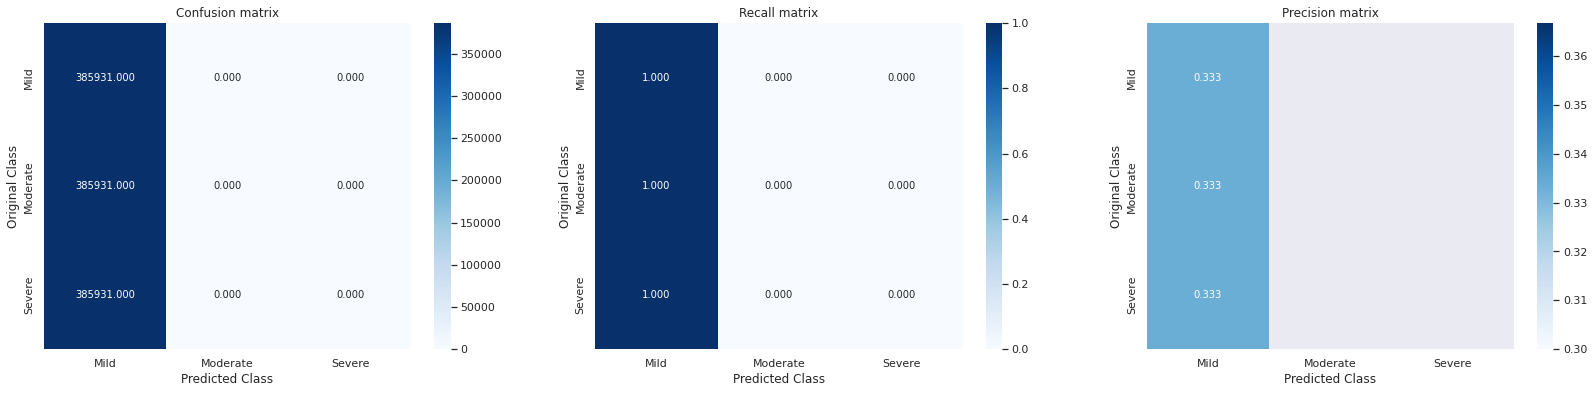


Confusion matrix on test data


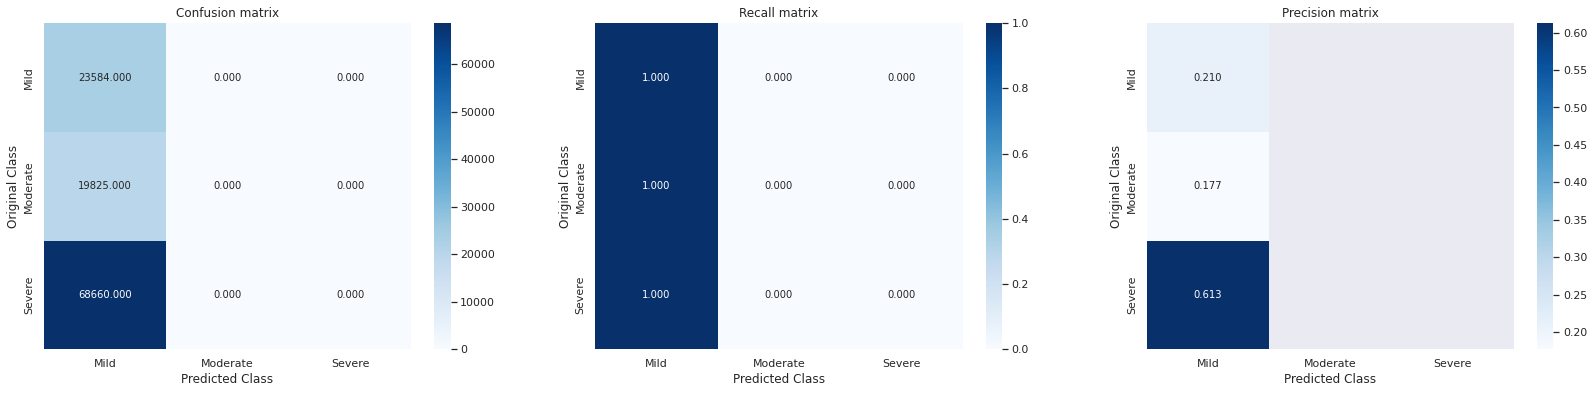


Classification report on train data
              precision    recall  f1-score   support

        mild       0.33      1.00      0.50    385931
    moderate       0.00      0.00      0.00    385931
      severe       0.00      0.00      0.00    385931

    accuracy                           0.33   1157793
   macro avg       0.11      0.33      0.17   1157793
weighted avg       0.11      0.33      0.17   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.21      1.00      0.35     23584
    moderate       0.00      0.00      0.00     19825
      severe       0.00      0.00      0.00     68660

    accuracy                           0.21    112069
   macro avg       0.07      0.33      0.12    112069
weighted avg       0.04      0.21      0.07    112069



In [ ]:
summary.add_row(['random', train_f1_score, test_f1_score])
plot_results()

We will use this score as our base score and build machine learning models that perform better than random model.

#### Logistic Regression

In [ ]:
# %%time
params = {'alpha': list(np.arange(0.0001, 1, 0.0001))}
LR = SGDClassifier(loss='log', n_jobs=-1, random_state=42)
LR_opt = TuneSearchCV(LR, params, scoring='f1_micro', n_jobs=-1, cv=3)
LR_opt.fit(X_tr_std, y_train.values.ravel())

print('\033[1mBest estimators:\033[0m', LR_opt.best_params_)

Best estimators: {'alpha': 0.0027}


In [ ]:
# joblib.dump(LR_opt, filepath+'models/LR_model.pkl')
LR_opt = joblib.load(filepath+'models/LR_model.pkl')

In [ ]:
y_tr_pred = LR_opt.predict(X_tr_std)
y_te_pred = LR_opt.predict(X_te_std)

train_f1_score = round(f1_score(y_train, y_tr_pred, average='micro'), 3)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 3)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.693
micro_f1_score on test data: 0.702


Confusion matrix on train data


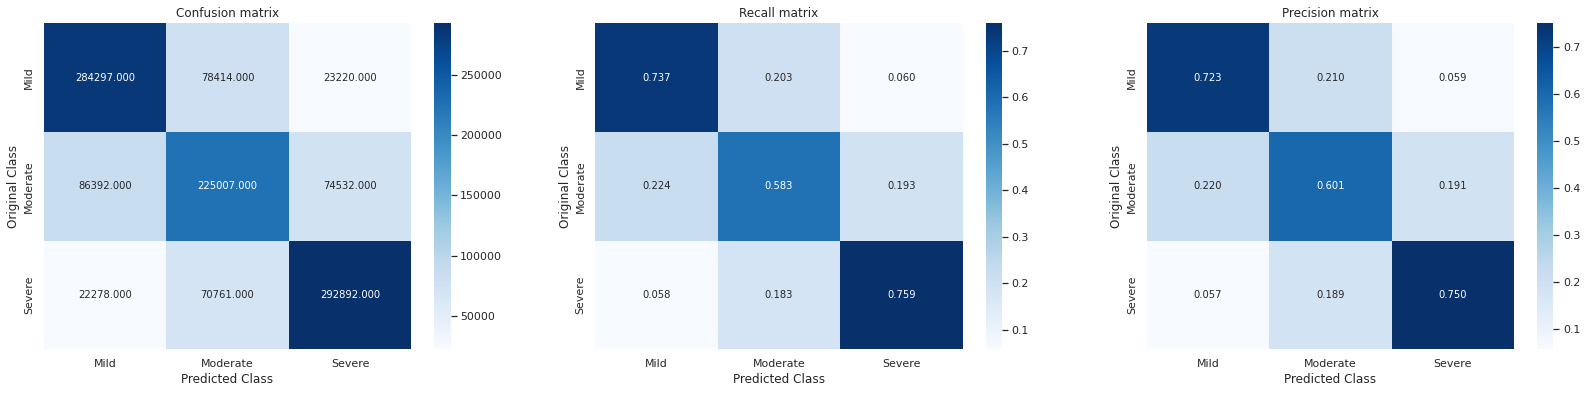


Confusion matrix on test data


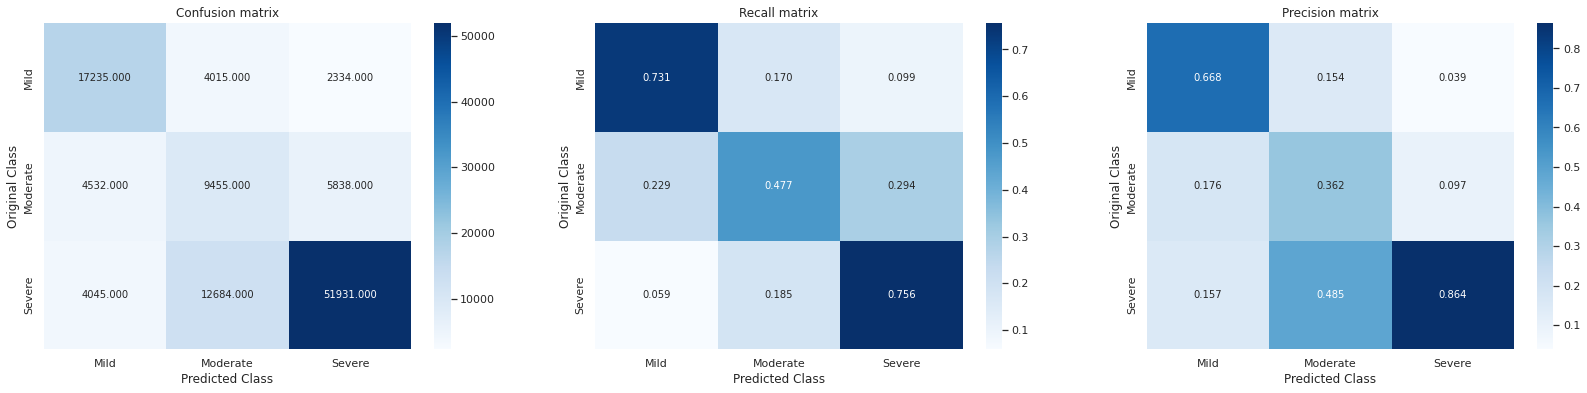


Classification report on train data
              precision    recall  f1-score   support

        mild       0.72      0.74      0.73    385931
    moderate       0.60      0.58      0.59    385931
      severe       0.75      0.76      0.75    385931

    accuracy                           0.69   1157793
   macro avg       0.69      0.69      0.69   1157793
weighted avg       0.69      0.69      0.69   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.67      0.73      0.70     23584
    moderate       0.36      0.48      0.41     19825
      severe       0.86      0.76      0.81     68660

    accuracy                           0.70    112069
   macro avg       0.63      0.65      0.64    112069
weighted avg       0.73      0.70      0.71    112069



In [ ]:
summary.add_row(['logistic_reg', train_f1_score, test_f1_score])
plot_results()

#### Linear SVC

In [ ]:
%%time

params = {'alpha': list(np.arange(0.0001, 1, 0.001))}
SVC = SGDClassifier(loss='hinge', n_jobs=-1, random_state=42)
SVC_opt = TuneSearchCV(SVC, params, scoring='f1_micro', n_jobs=-1, cv=3)
SVC_opt.fit(X_tr_std, y_train.values.ravel())

print('\033[1mBest estimators:\033[0m', SVC_opt.best_params_)

In [ ]:
# joblib.dump(SVC_opt, filepath+'models/LinearSVC.pkl')
SVC_opt = joblib.load(filepath+'models/LinearSVC.pkl')

In [ ]:
y_tr_pred = SVC_opt.predict(X_tr_std)
y_te_pred = SVC_opt.predict(X_te_std)

train_f1_score = round(f1_score(y_train, y_tr_pred, average='micro'), 3)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 3)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.682
micro_f1_score on test data: 0.704


Confusion matrix on train data


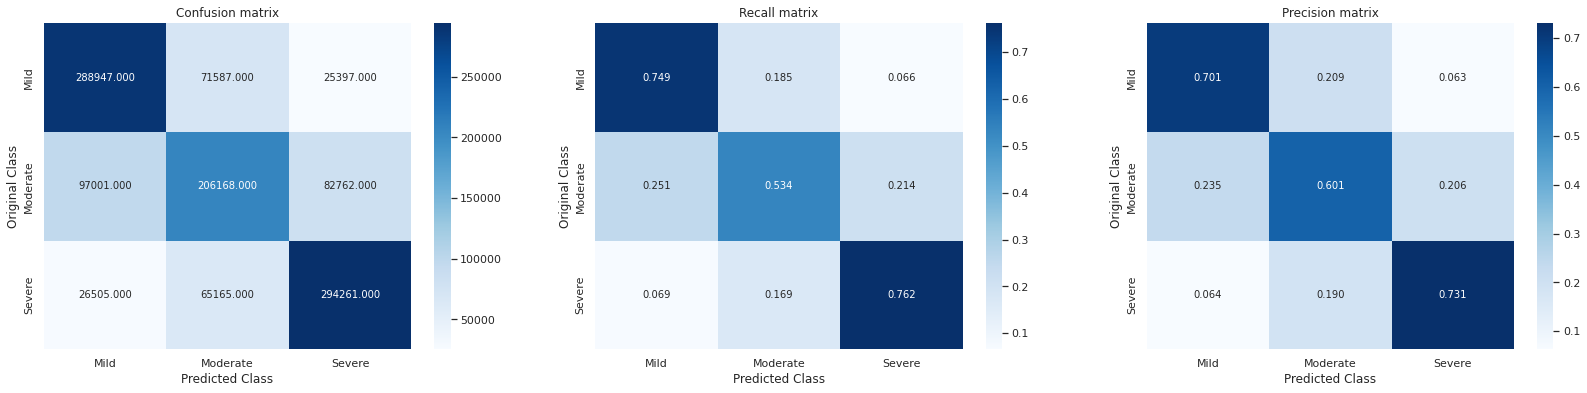


Confusion matrix on test data


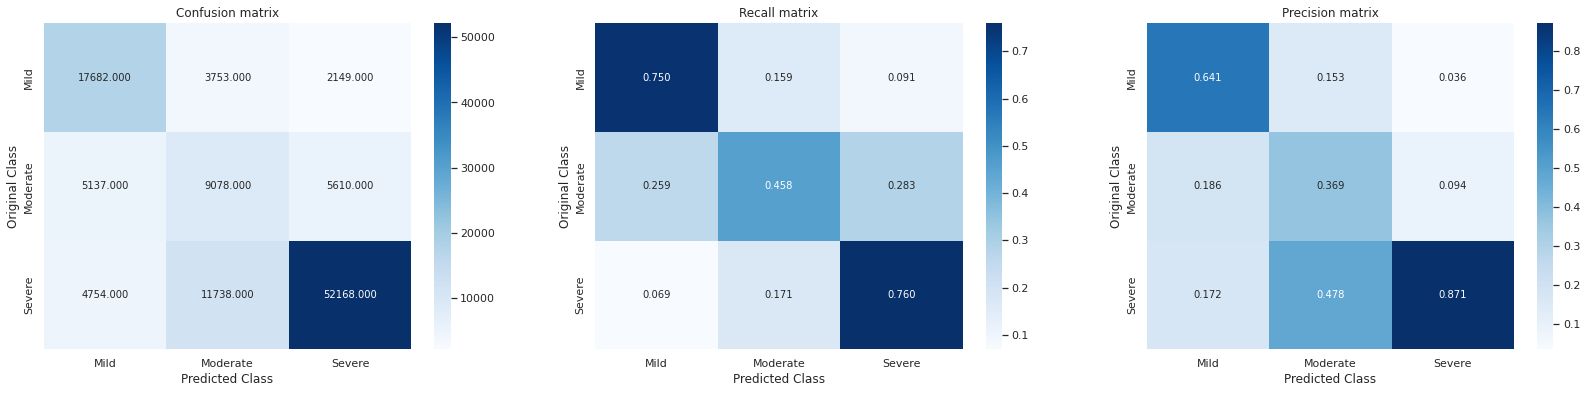


Classification report on train data
              precision    recall  f1-score   support

        mild       0.70      0.75      0.72    385931
    moderate       0.60      0.53      0.57    385931
      severe       0.73      0.76      0.75    385931

    accuracy                           0.68   1157793
   macro avg       0.68      0.68      0.68   1157793
weighted avg       0.68      0.68      0.68   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.64      0.75      0.69     23584
    moderate       0.37      0.46      0.41     19825
      severe       0.87      0.76      0.81     68660

    accuracy                           0.70    112069
   macro avg       0.63      0.66      0.64    112069
weighted avg       0.73      0.70      0.71    112069



In [ ]:
summary.add_row(['Linear_SVC', train_f1_score, test_f1_score])
plot_results()

#### Decision Trees

In [ ]:
%%time
params = {'max_depth': list(range(10,101)), 'min_samples_split': list(range(2,501)),
          'min_samples_leaf': list(range(20,501))}
DT = DecisionTreeClassifier(random_state=42)
DT_opt = TuneSearchCV(DT, params, scoring='f1_micro', n_jobs=-1, cv=3, random_state=42)
DT_opt.fit(X_tr_std, y_train.values.ravel())

print('\033[1mBest estimators:\033[0m', DT_opt.best_params_)

Best estimators: {'max_depth': 81, 'min_samples_split': 190, 'min_samples_leaf': 40}
CPU times: user 3min 9s, sys: 5.89 s, total: 3min 15s
Wall time: 19min 32s


In [ ]:
# joblib.dump(DT_opt, filepath+'models/DT_model.pkl')
DT_opt = joblib.load(filepath+'models/DT_model.pkl')

In [ ]:
y_tr_pred = DT_opt.predict(X_tr_std)
y_te_pred = DT_opt.predict(X_te_std)

train_f1_score = round(f1_score(y_train, y_tr_pred, average='micro'), 3)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 3)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.756
micro_f1_score on test data: 0.715


Confusion matrix on train data


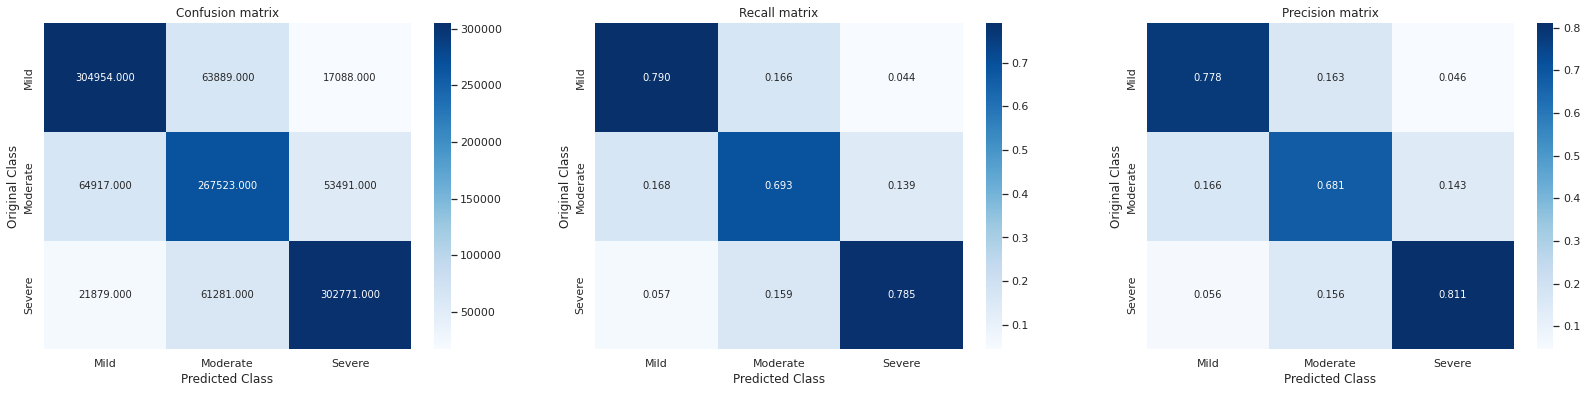


Confusion matrix on test data


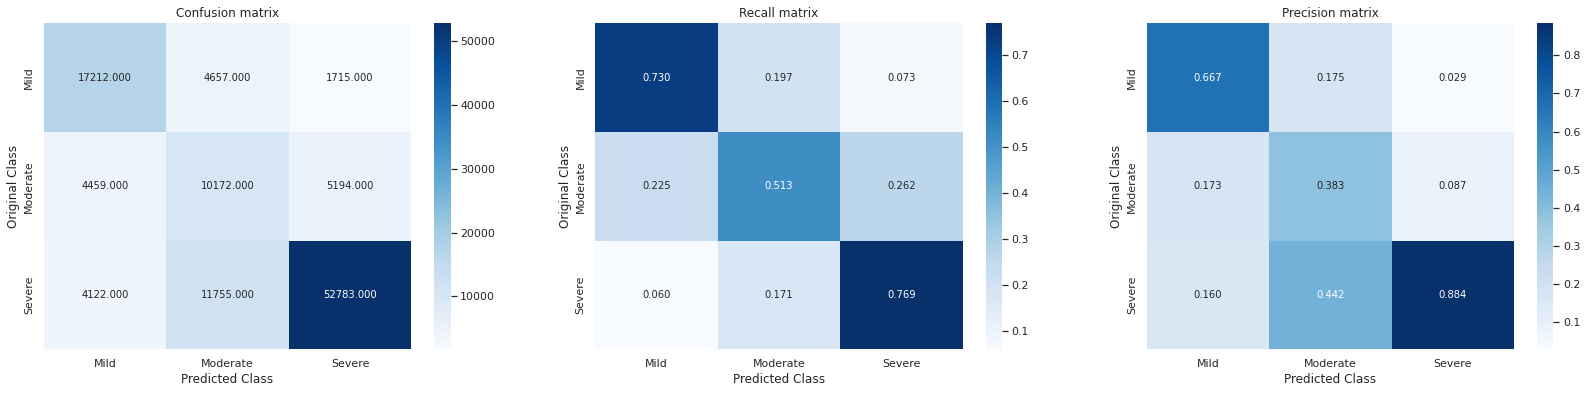


Classification report on train data
              precision    recall  f1-score   support

        mild       0.78      0.79      0.78    385931
    moderate       0.68      0.69      0.69    385931
      severe       0.81      0.78      0.80    385931

    accuracy                           0.76   1157793
   macro avg       0.76      0.76      0.76   1157793
weighted avg       0.76      0.76      0.76   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.67      0.73      0.70     23584
    moderate       0.38      0.51      0.44     19825
      severe       0.88      0.77      0.82     68660

    accuracy                           0.72    112069
   macro avg       0.64      0.67      0.65    112069
weighted avg       0.75      0.72      0.73    112069



In [ ]:
summary.add_row(['decision_trees', train_f1_score, test_f1_score])
plot_results()

#### Random Forest

In [ ]:
%%time
params = {'n_estimators': list(range(100,801)), 'max_depth': list(range(10,101)),
          'max_samples': list(np.arange(0.1,1,0.1)), 'max_features': list(np.arange(0.1,1,0.1))}

RF = RandomForestClassifier(random_state=42)
RF_opt = TuneSearchCV(RF, params, scoring='f1_micro', n_jobs=-1, cv=3, random_state=42)
RF_opt.fit(X_tr_emb, y_train.values.ravel())

RF_opt =  RandomForestClassifier(random_state=42, n_estimators=502, max_depth=22, max_features=0.12, max_samples=0.15)
RF_opt.fit(X_tr_std, y_train.values.ravel())

print('\033[1mBest estimators:\033[0m', RF_opt)

Best estimators: RandomForestClassifier(max_depth=22, max_features=0.12, max_samples=0.15,
                       n_estimators=502, random_state=42)
CPU times: user 41min 49s, sys: 1.86 s, total: 41min 51s
Wall time: 41min 58s


The RF model is hyperparameter tuned separately without using randomizedsearch or gridsearch due to resource constraint. Further hyperparameter tuning can be done.

In [ ]:
joblib.dump(RF_opt, filepath+'models/RF_model.pkl')
# RF_opt = joblib.load(filepath+'models/RF_model.pkl')

In [ ]:
y_tr_pred = RF_opt.predict(X_tr_std)
y_te_pred = RF_opt.predict(X_te_std)

train_f1_score = round(f1_score(y_train, y_tr_pred, average='micro'), 3)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 3)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.839
micro_f1_score on test data: 0.742


Confusion matrix on train data


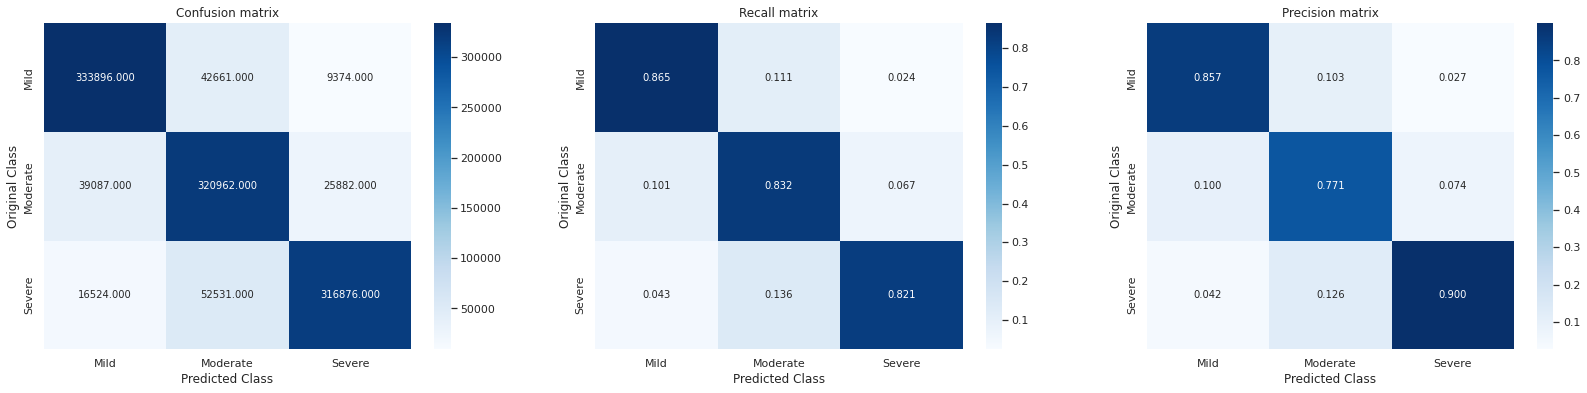


Confusion matrix on test data


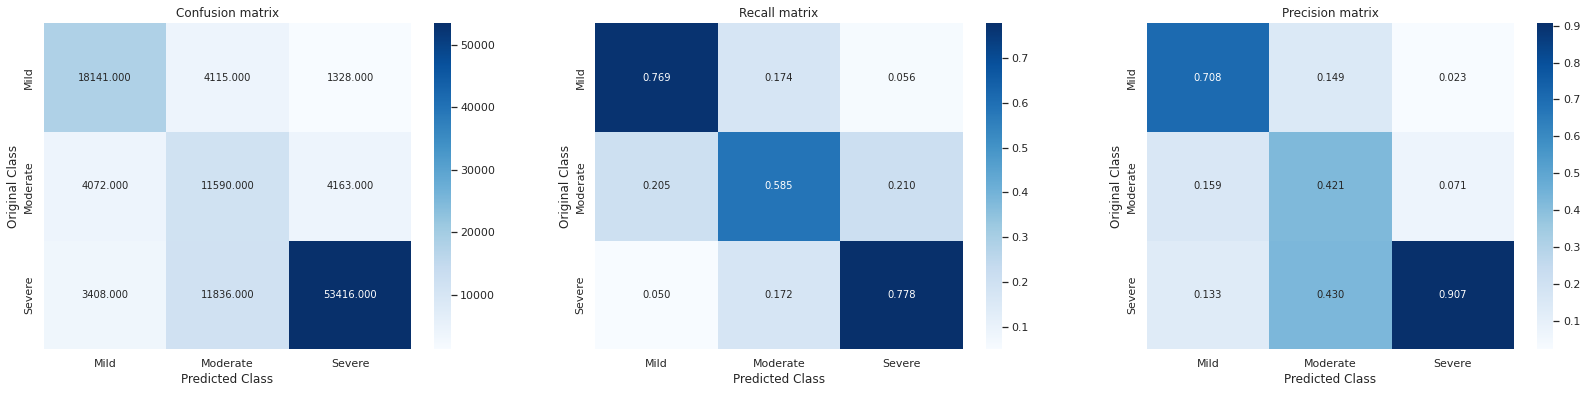


Classification report on train data
              precision    recall  f1-score   support

        mild       0.86      0.87      0.86    385931
    moderate       0.77      0.83      0.80    385931
      severe       0.90      0.82      0.86    385931

    accuracy                           0.84   1157793
   macro avg       0.84      0.84      0.84   1157793
weighted avg       0.84      0.84      0.84   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.71      0.77      0.74     23584
    moderate       0.42      0.58      0.49     19825
      severe       0.91      0.78      0.84     68660

    accuracy                           0.74    112069
   macro avg       0.68      0.71      0.69    112069
weighted avg       0.78      0.74      0.75    112069



In [ ]:
summary.add_row(['random_forest', train_f1_score, test_f1_score])
plot_results()

#### Gradient Boosting: Lightgbm




In [ ]:
# %%time
LGB = LGBMClassifier(device_type='gpu')

param_dist = {'n_estimators': range(100, 401), 'max_depth':range(2,20),
             'colsample_bytree': np.arange(0.1,0.5,0.1), 'subsample': np.arange(0.1,0.5,0.1),
             'num_leaves': range(20,100)}

LGB_opt = RandomizedSearchCV(LGB, param_dist, random_state=42, cv=2,
                       scoring='f1_micro', n_jobs=-1)

LGB_opt.fit(X_tr_std, y_train.values.ravel())

print('\033[1mBest estimators:\033[0m', LGB_opt.best_params_)

In [ ]:
# optimized LGB model
LGB_opt = LGBMClassifier(device_type='gpu', subsample = 0.3, num_leaves = 98,
                         n_estimators = 350, max_depth = 16, colsample_bytree=0.3)

LGB_opt.fit(X_tr_std, y_train.values.ravel())

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 23711
[LightGBM] [Info] Number of data points in the train set: 1157793, number of used features: 243
[LightGBM] [Info] Using GPU Device: Quadro M4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 180 dense feature groups (198.75 MB) transferred to GPU in 0.081834 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(colsample_bytree=0.3, device_type='gpu', max_depth=16,
               n_estimators=350, num_leaves=98, subsample=0.3)

In [ ]:
# joblib.dump(LGB_opt, filepath+'models/LGB_model.pkl')
LGB_opt = joblib.load(filepath+'models/LGB_model.pkl')

In [ ]:
%%time
y_tr_pred = LGB_opt.predict(X_tr_std)
y_te_pred = LGB_opt.predict(X_te_std)

train_f1_score = round(f1_score(y_train, y_tr_pred, average='micro'), 3)
test_f1_score = round(f1_score(y_test, y_te_pred, average='micro'), 3)
print('micro_f1_score on train data:', train_f1_score)
print('micro_f1_score on test data:', test_f1_score)

micro_f1_score on train data: 0.816
micro_f1_score on test data: 0.775
CPU times: user 5min 1s, sys: 2.32 s, total: 5min 3s
Wall time: 55.7 s


Confusion matrix on train data


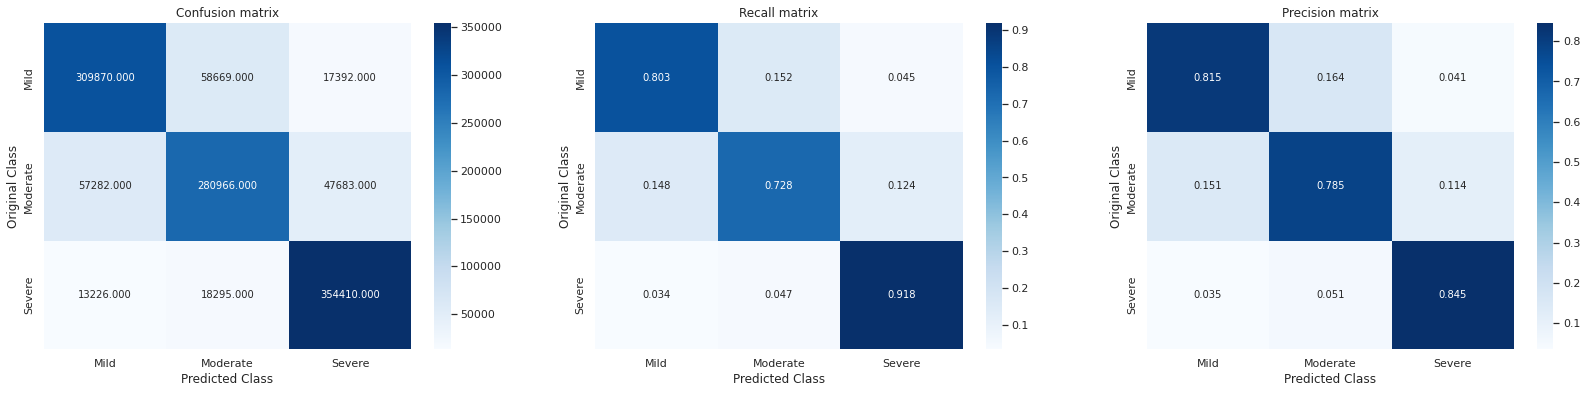


Confusion matrix on test data


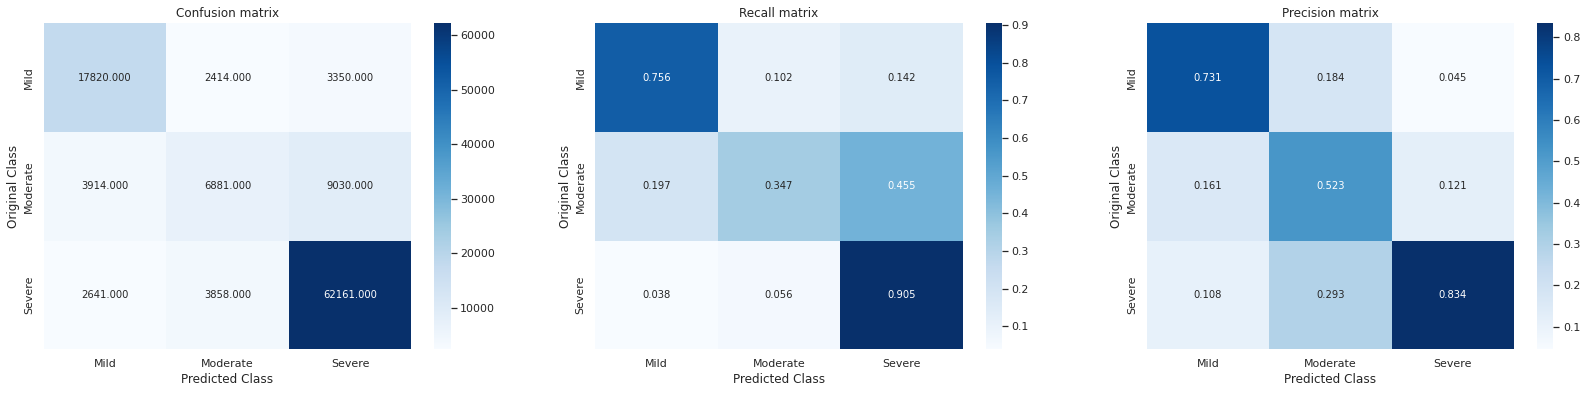


Classification report on train data
              precision    recall  f1-score   support

        mild       0.81      0.80      0.81    385931
    moderate       0.78      0.73      0.76    385931
      severe       0.84      0.92      0.88    385931

    accuracy                           0.82   1157793
   macro avg       0.81      0.82      0.81   1157793
weighted avg       0.81      0.82      0.81   1157793


Classification report on test data
              precision    recall  f1-score   support

        mild       0.73      0.76      0.74     23584
    moderate       0.52      0.35      0.42     19825
      severe       0.83      0.91      0.87     68660

    accuracy                           0.78    112069
   macro avg       0.70      0.67      0.68    112069
weighted avg       0.76      0.78      0.76    112069



In [ ]:
summary.add_row(['LightGBM', train_f1_score, test_f1_score])
plot_results()

### Summary

In [ ]:
# print summary table
print('\033[1m Summary of models\033[0m')
print(summary)
print('\n\n')

 Summary of models
+----------------+----------------+---------------+
|     model      | train_f1_score | test_f1_score |
+----------------+----------------+---------------+
|     random     |     0.333      |      0.21     |
|  logistic_reg  |     0.693      |     0.702     |
|   Linear_SVC   |     0.682      |     0.704     |
| decision_trees |     0.756      |     0.715     |
| random_forest  |     0.839      |     0.742     |
|    LightGBM    |     0.816      |     0.775     |
+----------------+----------------+---------------+





Observation

    1. Performance of linear models is lower than that of our embedding neural network model as expected
    2. Random Forest is performing on par with that of our embedding neural network model
    3. Lightgbm is outperforming all other models

### Feature Importance

Lets look at feature importance for lightgbm

In [ ]:
# sorted(zip(X.columns, clf.feature_importances_), reverse=True)
feature_imp = pd.DataFrame(zip(X_tr_std.columns, LGB_opt.feature_importances_), columns=['Feature','Value'])
feature_imp['Importance'] = feature_imp['Value'] / feature_imp['Value'].sum()
feature_imp = feature_imp.sort_values(by='Value', ascending=False)

In [ ]:
# Variance
for i in range(10,244,10):
    print('Variance explained by top', i, 'features:', round(feature_imp[:i]['Importance'].sum()*100,2))

Variance explained by top 10 features: 17.65
Variance explained by top 20 features: 25.31
Variance explained by top 30 features: 32.59
Variance explained by top 40 features: 39.6
Variance explained by top 50 features: 46.33
Variance explained by top 60 features: 52.22
Variance explained by top 70 features: 56.88
Variance explained by top 80 features: 60.86
Variance explained by top 90 features: 64.63
Variance explained by top 100 features: 68.15
Variance explained by top 110 features: 71.56
Variance explained by top 120 features: 74.82
Variance explained by top 130 features: 77.93
Variance explained by top 140 features: 80.91
Variance explained by top 150 features: 83.67
Variance explained by top 160 features: 86.3
Variance explained by top 170 features: 88.81
Variance explained by top 180 features: 91.2
Variance explained by top 190 features: 93.48
Variance explained by top 200 features: 95.59
Variance explained by top 210 features: 97.44
Variance explained by top 220 features: 98.78


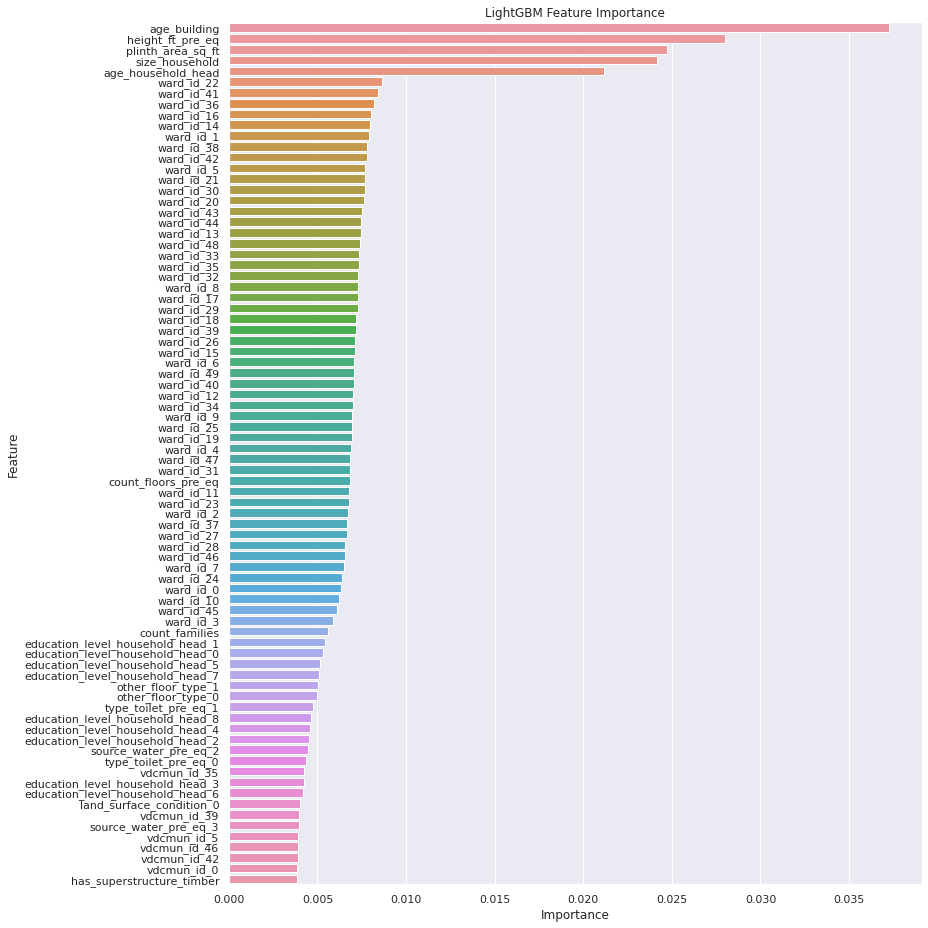

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(13,13))
sns.barplot(x='Importance', y='Feature', data=feature_imp[:80])
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()
plt.savefig(filepath+'lgbm_feature_imp.png')

Observation

    1. Top 5 features are age of building, height of building, plinth area, size of household and age of household head
    2. Building structure details like geo-location, age, area, number of floors, construction, etc
    are playing vital role in determining the severity of damage  
    3. Interestingly we can see that socio-economic features like size of household, age of household head, education level, type of toilet,
    source of water, etc are also playing important role in determining the severity of damage
    4. Embedded features obtained using neural network is also capturing most of the variance in the data
    5. The performance of model decreases if we reduce the number of dimension as most features are required to explain the majority of variance